In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import numpy as np
from matplotlib import pyplot as plt
from regularization_helper import plot_it, get_simple_dataset, get_polynimial_set, plot_classifier, save_dataset
from sklearn import model_selection
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras import optimizers
from fnn_helper import PlotLosses
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras import regularizers

## Cargo y ploteo dataset

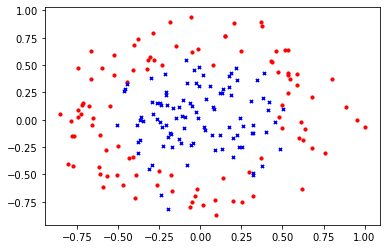

In [10]:
dataset_200 = np.load('data/200_samples_OK.npy')
X = dataset_200[:,:2]
y = dataset_200[:, 2]
plot_it(X,y)
plt.show()

In [17]:
dataset_200[0,2]

1.0

## Defino el modelo

In [88]:
def get_two_layer_model_fixed():
    input_shape=2
    output_size=1
    hidden_units= 10
    lr=2
    decay=0.0
    model = Sequential()
    sgd = optimizers.SGD(lr=lr, decay=decay)
    model.add(Dense(hidden_units,input_dim=input_shape,  activation='sigmoid', ))
    model.add(Dense(output_size, 
                    activation='sigmoid', 
                    kernel_initializer='zeros', 
                    name='Salida'
                   ))
    model.compile(loss = 'binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

# K-fold Cross Validation
- No tengo un dataset grande
- Pros: Ayuda a validar mejor el modelo
- Cons: Puede llevar tiempo
- Podriamos haber separado el test set y trabajar con el training set para dividirlo

In [89]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(10)

In [90]:
i=0
training_sets = []
for train_index, test_index in skf.split(X, y):
    i=i+1
    print("CV dataset:", i)
    print(train_index.shape, test_index.shape)
    dictionary = {'X_train':X[train_index], 'y_train':y[train_index], 'X_test':X[test_index],'y_test':y[test_index]}
    training_sets.append(dictionary)

CV dataset: 1
(180,) (20,)
CV dataset: 2
(180,) (20,)
CV dataset: 3
(180,) (20,)
CV dataset: 4
(180,) (20,)
CV dataset: 5
(180,) (20,)
CV dataset: 6
(180,) (20,)
CV dataset: 7
(180,) (20,)
CV dataset: 8
(180,) (20,)
CV dataset: 9
(180,) (20,)
CV dataset: 10
(180,) (20,)


## Grafico uno de los train/test sets

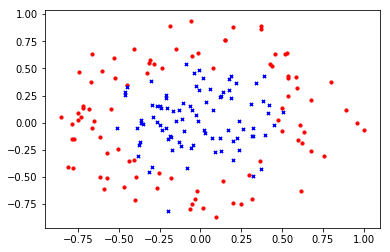

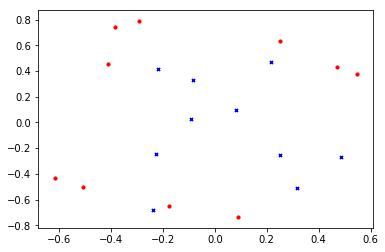

In [128]:
idx = 1
plot_it(training_sets[idx]['X_train'],training_sets[idx]['y_train'])
plt.show()
plot_it(training_sets[idx]['X_test'],training_sets[idx]['y_test'])
plt.show()

## Entreno de manera tradicional uno de los k-folds

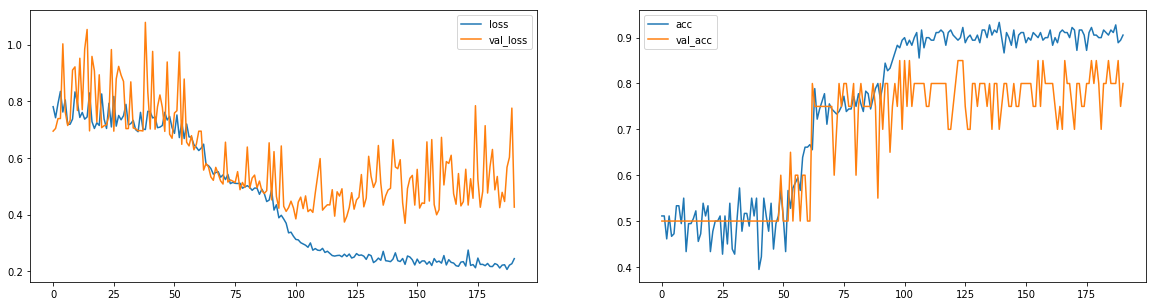

In [95]:
idx = 1
plot_losses = PlotLosses(plot_interval=10, evaluate_interval=None, x_val=training_sets[idx]['X_test'], y_val_categorical=training_sets[idx]['y_test'])

two_layer_model = get_two_layer_model_fixed()
two_layer_model.fit(training_sets[idx]['X_train'], 
          training_sets[idx]['y_train'], batch_size = 25,
          epochs=200, 
          verbose=0, 
          validation_data=(training_sets[idx]['X_test'], training_sets[idx]['y_test']), 
          callbacks=[plot_losses],
         )

## Entreno usando cross_val_scores de SciKitLearn

In [96]:
from sklearn.model_selection import cross_val_score
# cross_val_score(classifier, X, y, cv, n_jobs=)
# El problema es que el 'classifier' es de sklearn y tenemos uno de Keras
# Por lo tanto hay que utilizar un wrapper
from keras.wrappers.scikit_learn import KerasClassifier

In [97]:
classifier = KerasClassifier(get_two_layer_model_fixed, batch_size=25,  
                             epochs=100, verbose=0)
cross_val_scores = cross_val_score(estimator=classifier, X=X, y=y, cv=skf, 
                                   scoring='accuracy') # n_jobs=-1

In [98]:
cross_val_scores

array([ 0.9 ,  0.9 ,  0.9 ,  0.85,  0.95,  0.9 ,  1.  ,  0.8 ,  0.85,  0.9 ])

In [99]:
cross_val_scores.mean(), cross_val_scores.std()

(0.89500000000000013, 0.052201532544552745)

- low, high accuracy and low, high variance
- high variance --> overfitting

# Ajuste de Hyperparametros (Parameter tunning)

In [113]:
from sklearn.model_selection import GridSearchCV

In [115]:
def get_two_layer_model_variable(lr, hidden_units):
    input_shape=2
    output_size=1
    optimizer = optimizers.SGD(lr=lr, decay=0.0)
    model = Sequential()
    model.add(Dense(hidden_units,input_dim=input_shape,  activation='sigmoid', ))
    model.add(Dense(output_size, 
                    activation='sigmoid', 
                    kernel_initializer='zeros', 
                    name='Salida'
                   ))
    model.compile(loss = 'binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
classifier_variable = KerasClassifier(build_fn=get_two_layer_model_variable, epochs=100, verbose=0)

In [116]:
#sgd = optimizers.SGD(lr=2, decay=0.0)
parameters = {
    'batch_size': [25,100], 
    'lr': [2,1],
    'hidden_units': [3,10]
             }

In [117]:
grid_search = GridSearchCV(estimator=classifier_variable, cv=skf, param_grid=parameters, scoring='accuracy')

In [119]:
grid_search.fit(X=X, y=y, verbose=1)

Epoch 1/100
180/180 [==============================] - 3s - loss: 0.7148 - acc: 0.4222      
Epoch 2/100
180/180 [==============================] - 0s - loss: 0.6982 - acc: 0.4889     
Epoch 3/100
180/180 [==============================] - 0s - loss: 0.7528 - acc: 0.4722     
Epoch 4/100
180/180 [==============================] - 0s - loss: 0.7797 - acc: 0.4722     
Epoch 5/100
180/180 [==============================] - 0s - loss: 0.7067 - acc: 0.4889     
Epoch 6/100
180/180 [==============================] - 0s - loss: 0.7194 - acc: 0.5056     
Epoch 7/100
180/180 [==============================] - 0s - loss: 0.7521 - acc: 0.4389     
Epoch 8/100
180/180 [==============================] - 0s - loss: 0.7194 - acc: 0.4500     
Epoch 9/100
180/180 [==============================] - 0s - loss: 0.7768 - acc: 0.3833     
Epoch 10/100
180/180 [==============================] - 0s - loss: 0.7146 - acc: 0.4778     
Epoch 11/100
180/180 [==============================] - 0s - loss: 0.7259 - ac

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x160539080>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'batch_size': [25, 100], 'lr': [2, 1], 'hidden_units': [3, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [120]:
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

In [121]:
best_parameters

{'batch_size': 25, 'hidden_units': 10, 'lr': 2}

In [122]:
best_accuracy

0.88500000000000001